In [78]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import subprocess

%matplotlib inline  
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 8]

# 'am' tutorial

The program "am", written by Scott Paine, is available here:
https://lweb.cfa.harvard.edu/~spaine/am/

If you download and install it, you can find a bunch of site-specific configuration files
in its 'cookbook/sites' and 'cookbook/other_examples' files.

For example, in 'cookbook/sites/Spole', you'll find files with names like:

SPole_DJF_25.amc

Here, "SPole" indicates the site, "DJF" indicates a three month window (a quarter of the year), in this case December/January/February, and "25" indicates "the 25th percentile pwv (precipitable water vapor)".

Looking in one of those files, after the comments at the top you'll see instructions on how to run am:
~~~
?
? Usage:
?  am SPole_DJF_25.amc  f_min  f_max  df  zenith_angle  trop_h2o_scale_factor
?
? Example:
?  am SPole_DJF_25.amc  0 GHz  300 GHz  10 MHz  0 deg  1.0
?
~~~

This is pretty straightforward;  it will calculate the atmospheric spectra from 0 to 300GHz, with frequency steps of 10MHz, looking straight up (zeith angle = 0 degrees), with a "troposphere_h2o_scale_factor" set to 1.0.

The "troop_h20_scale_factor" is used to calculate the effect of variable levels of pwv, in that same season
from that same site.  More on that later.

Let's look at the next few lines, and what they do.  (I've added comments that explain what each does).

~~~
f %1 %2  %3 %4  %5 %6                    # Sets the frequency info using command-line arguments 1-6.
output f GHz  tau  tx  Trj K  Tb K       # Sets up what columns to output (including their units where applicable)
za %7 %8                                 # Zenith angle at which to calculate.
tol 1e-4                                 # Sets how converged things have to be.

Nscale troposphere h2o %9                # A factor to scale pwv

T0 2.7 K                                 # Include the CMB radiation in the output irradiances.
~~~

This is all quite straightforward;  pay attention to the "output" line, as that sets what will be written out to a file.  The default in the example files is columns of frequency in GHz, then optical depth (tau), then transmission (tx), then the brightness in Rayleigh-Jeans Kelvin, and then the brightness in Planck (blackbody) Kelvin.

Note that the brightness outputs, as configured by default, include the effect of having the CMB incident on the atmosphere from above, getting down (as much as it can) to the ground and adding to the total irradiance.  So, if you want to compute and print out only the atmospheric irradiance, you need to modify the line starting 'T0'.  I think you can comment it out, but you can probably also just set it to 0 K.

~~~
T0 0.0 K
~~~

Now, looking below those lines, you see the rest of the file is broken into blocks, like
~~~
layer mesosphere
Pbase 0.1 mbar
Tbase 229.8 K
lineshape Voigt-Kielkopf
column dry_air vmr
column h2o vmr 6.95e-06
column o3 vmr 5.97e-07

layer mesosphere
Pbase 0.3 mbar
Tbase 259.4 K
lineshape Voigt-Kielkopf
column dry_air vmr
column h2o vmr 6.96e-06
column o3 vmr 7.98e-07

(etc)
~~~

This is describing layers in the atmosphere by their pressure, working down from the top (low pressure) to the bottom (high pressure) layers, each with a bespoke pressure, temperature, and densities of components such as water and ozone.

The first layers are in the mesosphere, then comes the stratosphere, then the troposphere.  The troposphere contains almost all the water vapor, and it is there that the "trop_h2o_scale_factor" operates to change the pwv.


# How to run 'am'
Now that we understand and have set up the .amc file we want to run (don't forget to fix the T0 problem if you only want the atmosphere!), we can just follow the directions and, at the command line, run it as suggested like this:

~~~
jr_mac$  am SPole_annual_50.amc  0 GHz  300 GHz  10 MHz  0 deg  1.0
~~~

There are a few problems here.  The first is that 10MHz is really narrow frequency spacing, so it will take a bit of time.  We generally don't need that fine spacing, so I often run with 0.1GHz = 100MHz spacing.  We also shouldn't start at 0GHz (it makes the curves look weird) so I start at 1GHz.

The second problem is that this command spits all the output to the terminal, but we'd rather store it in a file.
So, we can use the output redirect available in unix:

~~~
jr_mac$  am SPole_annual_50.amc  1 GHz  300 GHz  100 MHz  0 deg  1.0 > SPole_annual_50.dat
~~~

That's a little better, but a bunch of potentially useful stuff is still spit out to the terminal!   This is am's "error" stuff, which is really a bunch of "log" information that we'd like to store.  We can get even fancier and send the "error" stuff to a different file, like this:

~~~
jr_mac$  am SPole_annual_50.amc  1 GHz  300 GHz  100 MHz  0 deg  1.0 > SPole_annual_50.dat 2> SPole_annual_50.log
~~~

So, I recommend that last version, which saves the log stuff so you can look at it later.

Having done this, let's look at the top of the ".dat" file, except that I'm adding a comment
line that says what each column is, based on what was in the .amc file.
~~~
# freq (GHz)     tau          tx          T_rj (K)    T_bb (K)
0.000000e+00 2.555541e-08 1.000000e+00 0.000000e+00 0.000000e+00
1.000000e-01 6.461032e-04 9.993541e-01 1.400691e-01 1.424552e-01
2.000000e-01 1.569403e-03 9.984318e-01 3.455968e-01 3.503741e-01
3.000000e-01 2.343640e-03 9.976591e-01 5.206131e-01 5.277793e-01
4.000000e-01 2.914443e-03 9.970898e-01 6.507268e-01 6.602788e-01
5.000000e-01 3.319644e-03 9.966859e-01 7.435301e-01 7.554647e-01
6.000000e-01 3.606879e-03 9.963996e-01 8.095002e-01 8.238141e-01
7.000000e-01 3.813353e-03 9.961939e-01 8.570036e-01 8.736933e-01
8.000000e-01 3.964773e-03 9.960431e-01 8.918781e-01 9.109403e-01
9.000000e-01 4.078155e-03 9.959301e-01 9.180091e-01 9.394402e-01
~~~

That's pretty self explanatory, and we'll plot things soon.  First, let's look at the .log file and 
see what is interesting there.  The first block of lines confirms what we set up in the amc file, 
and tells us what version am we used and how long it took to run.  This is where we could look 
to identify the columns if we forgot what they were.  (I like keeping the .amc, .dat, and .log files together forever, if possible, for this reason).
~~~
# am version 13.0 (build date Sep 26 2023 19:26:47)

# run time 0.016 s
# dcache hit: 300  miss: 0  discard: 0

f 1 GHz  300 GHz  100 MHz
output f GHz  tau neper  tx none  Trj K  Tb K

tol 0.0001
selfbroad_vmr_tol 0.003

geometry plane-parallel
refract none
za 0 deg
PTmode Pbase Tbase

g 980.665 cm*s^-2
dg_dz 0 s^-2

Nscale troposphere h2o 1

T0 0 K
~~~
Note also that we've confirmed that we did set T0 = 0K.

After that there are a bunch of reports about the layers, 
including some things saying our frequency bins are too wide 
to resolve some lines, which we'll ignore.

Near the very bottom of the file we see this interesting block:
~~~
#
# column densities [cm^-2], including scale factors
#
#                           zenith             line-of-sight     
# mesosphere (5 layers):
#                  dry_air  1.484114e+22       1.484114e+22      
#                      h2o  8.618523e+16       8.618523e+16      
#                            (0.0257831 um_pwv) (0.0257831 um_pwv)
#                       o3  1.810632e+16       1.810632e+16      
#                            (0.673899 DU)      (0.673899 DU)     
#
# stratosphere (12 layers):
#                  dry_air  1.469269e+24       1.469269e+24      
#                      h2o  7.811255e+18       7.811255e+18      
#                            (2.33681 um_pwv)   (2.33681 um_pwv)  
#                       o3  4.283559e+18       4.283559e+18      
#                            (159.43 DU)        (159.43 DU)       
#
# troposphere (13 layers):
#                  dry_air  1.301699e+25       1.301699e+25      
#                      h2o  1.414174e+21       1.414174e+21      
#                            (423.063 um_pwv)   (423.063 um_pwv)  
#                       o3  2.497310e+18       2.497310e+18      
#                            (92.9474 DU)       (92.9474 DU)      
#
# total (30 layers):
#                  dry_air  1.450110e+25       1.450110e+25      
#                      h2o  1.422071e+21       1.422071e+21      
#                            (425.426 um_pwv)   (425.426 um_pwv)  
#                       o3  6.798975e+18       6.798975e+18      
#                            (253.051 DU)       (253.051 DU)      
~~~

Here, of particular interest, is the reported number of microns of pwv.  In this case, we see that the 
troposphere has 423.063 microns of pwv, and the total atmosphere has 425.46 microns.  We can scale 
the tropospheric fraction using the trop_h2o_scale_factor command line argument discussed above to 
calculate the transmission and brightness at other values of pwv.

You might be asking, why are there quarterly (for example DJF) files, if we can just do this scaling?  Well, that's a good question.  The temperature and pressure profiles do vary throughout the year, so those quartly profiles capture the effects of that.  We can investigate, though, whether they make a significant difference, below.

Finally, let's plot our results!



In [79]:
f,tau,tx,Trj,Tb = np.loadtxt('SPole_annual_50.dat',unpack=True)

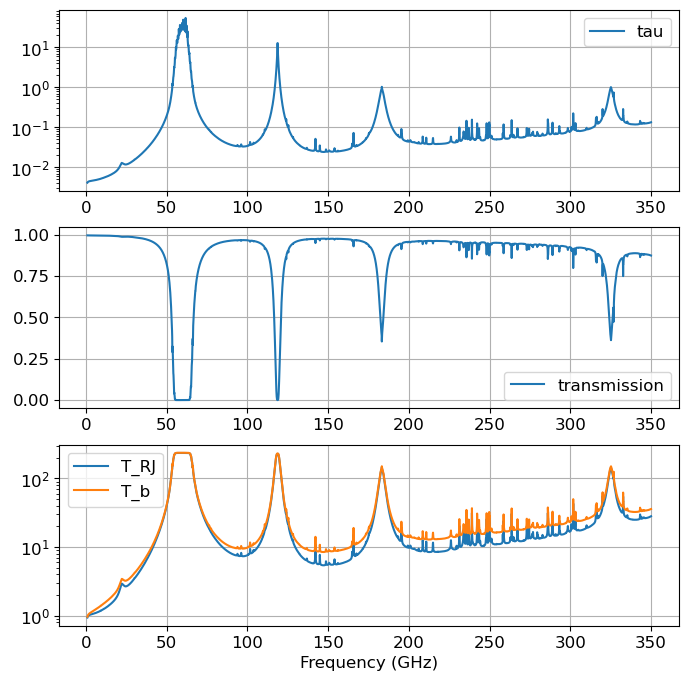

In [80]:
plt.subplot(3,1,1)
plt.semilogy(f,tau,label='tau')
plt.legend()
plt.grid()
#
plt.subplot(3,1,2)
plt.plot(f,tx,label="transmission")
plt.legend()
plt.grid()
#
plt.subplot(3,1,3)
plt.semilogy(f,Trj,label='T_RJ')
plt.semilogy(f,Tb,label='T_b')
plt.xlabel('Frequency (GHz)')
plt.legend()
plt.grid()
#

# Running a ton of examples

Here's a bash script, that will run on one file and put everything in the right place.

~~~
#!/bin/bash
# Name:  run_am_1.sh
# Usage:  ./run_am_1.sh SPole_annual_50

amcfile="$1.amc"
datfile="$1.dat"
logfile="$1.log"
echo "Running: $amcfile to $datfile and $logfile"
am $amcfile  1 GHz  350 GHz  100 MHz  0 deg  1.0 > $datfile 2> $logfile
~~~

And here's one that runs over every .amc file in a directory:

~~~
#!/bin/bash
# Name: run_am_all.sh
# Usage:  ./run_am_all.sh 
for file in *.amc
do
	# strip everything after the first '.', again, inclusive
	file="${file%%.*}"
	#echo "$file"
	./run_am_1.sh $file
done
~~~

Having done that on a bunch of examples, let's investigate the various outputs.

In [99]:
# First, let's look at all the log files and find out what the reported pwv's are.

def Get_AM_pwv(am_log_file):
    '''
    This function looks for the lines at the end of an am log file that contain the string 'um_pwv',
    and strips out the pwv values for the zenith (first instance on line) for the troposphere and total
    (second to last and last lines with this string, respectively).
    '''
    pwv_vec = np.array([])
    with open(am_log_file, 'r') as fp:
        for l_no, line in enumerate(fp):
            # search string
            if 'um_pwv' in line:
                # Get first (zenith) instance of pwv, which is the number between the first "(" and "u" characters.
                startchar = line.find('(')
                endchar = line.find(' u')
                pwv = float(line[startchar+1:endchar-1])
                pwv_vec=np.append(pwv_vec,pwv)
                #print('Line number: ',l_no,'  ',pwv)
    pwv_total = pwv_vec[-1]
    pwv_trop = pwv_vec[-2]
    return(pwv_total,pwv_trop)

# Iterate through all the log files and print out their total and tropospheric pwv's.
for logfile in sorted(glob.glob("*.log")):
    if 'balloon' not in logfile:
        pwv_total,pwv_trop = Get_AM_pwv(logfile)
        pwv_nottrop = pwv_total - pwv_trop
        print(logfile.ljust(22), ': ',pwv_total, pwv_trop, pwv_nottrop)

ACT_DJF_50.log         :  2271.5 2269.4 2.099999999999909
ACT_JFM_50.log         :  2313.3 2311.2 2.100000000000364
ACT_JJA_50.log         :  607.62 605.54 2.080000000000041
ACT_MAM_50.log         :  1101.2 1099.1 2.1000000000001364
ACT_SON_50.log         :  677.56 675.45 2.1099999999999
ACT_annual_50.log      :  931.52 929.44 2.0799999999999272
SPole_DJF_50.log       :  736.8 734.43 2.3700000000000045
SPole_JJA_50.log       :  267.36 265.89 1.4700000000000273
SPole_MAM_50.log       :  420.78 418.3 2.4799999999999613
SPole_SON_50.log       :  382.87 380.46 2.410000000000025
SPole_annual_50.log    :  425.42 423.06 2.3600000000000136
SPole_annual_50_tsf.log :  267.36 264.99 2.3700000000000045


# Scaling the pwv

Here's we'll use the pwv values above, and the tropospheric scaling factor, to rescale things to other pwv's.

Let's start by rescaling the SPole_annual_50 pwv to the JJA one, so we can see how much they differ by.

In [96]:
pwvs_model = np.array([425.42,423.06])
pwv_nontrop = pwvs_model[0]-pwvs_model[1]

pwv_desired = 267.36

# We want the total pwv's to match, so pwv_desired = pwv_nontrop + trop_scale_factor*pwv_model[1]
# which says trop_scale factor = (pwv_desired - pwv_nontrop)/pwv_model[1]

trop_scale_factor = (pwv_desired - pwv_nontrop)/pwvs_model[1]
print(trop_scale_factor)
tropstring = '{:.4f}'.format(trop_scale_factor)
print(tropstring)

fout = open('SPole_annual_50_tsf.dat','w')
ferr = open('SPole_annual_50_tsf.log','w')
# Run am with this scale factor
subprocess.run(['am','SPole_annual_50.amc','1','GHz','350','GHz','100','MHz','0','deg',tropstring],stdout=fout,stderr=ferr)
fout.close()
ferr.close()

0.6263886919113129
0.6264


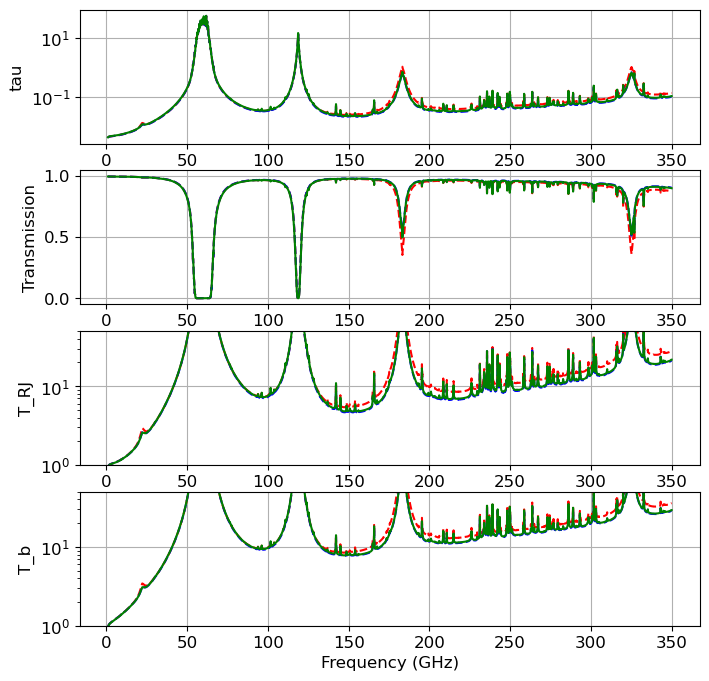

In [97]:
atmos1 = np.loadtxt('SPole_annual_50.dat',unpack=True)
atmos2 = np.loadtxt('SPole_annual_50_tsf.dat',unpack=True)
atmos3 = np.loadtxt('SPole_JJA_50.dat',unpack=True)

colors = ['r--','b--','green']

ii = 0
for atmos in [atmos1,atmos2,atmos3]:
    f = atmos[0]
    tau = atmos[1]
    tx = atmos[2]
    Trj = atmos[3]
    Tb = atmos[4]
    #
    plt.subplot(4,1,1)
    plt.semilogy(f,tau,colors[ii],label='tau')
    #
    plt.subplot(4,1,2)
    plt.plot(f,tx,colors[ii],label="transmission")
    #
    plt.subplot(4,1,3)
    plt.semilogy(f,Trj,colors[ii],label='T_RJ')
    #
    plt.subplot(4,1,4)
    plt.semilogy(f,Tb,colors[ii],label='T_b')
    ii = ii+1
    #
    
plt.subplot(4,1,1)
plt.ylabel('tau')
plt.grid()
#
plt.subplot(4,1,2)
plt.ylabel('Transmission')
plt.grid()
#
plt.subplot(4,1,3)
plt.ylabel('T_RJ')
plt.ylim(1,50)
plt.grid()
#
plt.subplot(4,1,4)
plt.ylabel('T_b')
plt.ylim(1,50)
plt.xlabel('Frequency (GHz)')
plt.grid()

Text(0, 0.5, 'delta T_b / Tb')

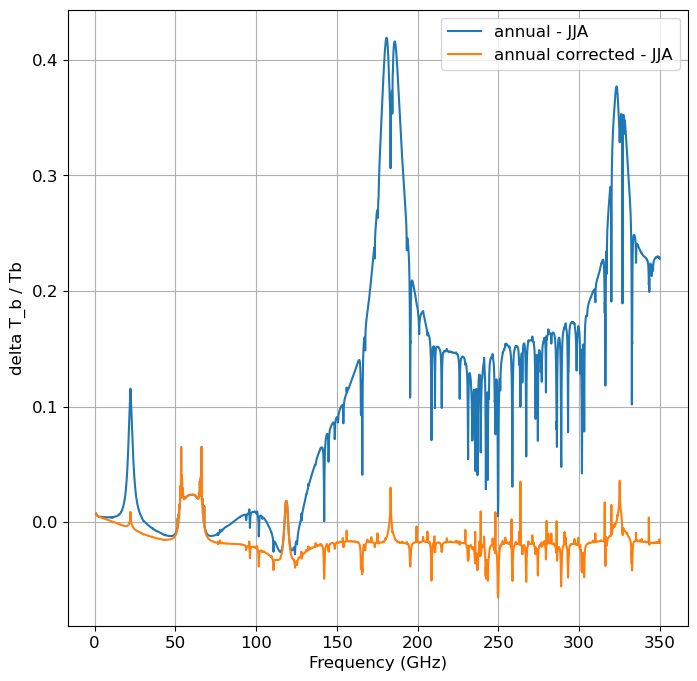

In [98]:
# now plot the fractional difference between Tb's in atmos2 and atmos3
#plt.plot(atmos2[0],atmos2[4])
plt.plot(atmos1[0],(atmos1[4]-atmos3[4])/atmos2[4],label='annual - JJA')
plt.plot(atmos2[0],(atmos2[4]-atmos3[4])/atmos2[4],label='annual corrected - JJA')
plt.grid()
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('delta T_b / Tb')

## Comments
So, we see that using trop_scale factor on the annual file (for south pole anyway) gets us to within a couple percent of the quarterly file.  This is "good enough" for most of our purposes.

Curiously, though, the JJA file has *more* emission at most frequencies than the corrected version, which I find surprising given the likelihood that the atmosphere is colder, overall.